# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [11]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

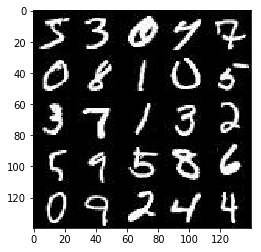

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

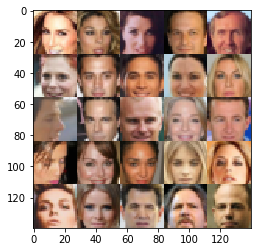

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

from tensorflow.contrib.layers import xavier_initializer

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [16]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_ = tf.placeholder(
        tf.float32,
        shape=[
            None,
            image_width,
            image_height,
            image_channels
        ],
        name='real_inputs'
    )
    z_inputs_ = tf.placeholder(
        tf.float32,
        shape=[None, z_dim],
        name='z_inputs'
    )
    learning_rate = tf.placeholder(
        tf.float32,
        name='learning_rate'
    )

    return (inputs_, z_inputs_, learning_rate)

    return None, None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [17]:
import numpy as np

def lrelu(x, alpha=0.1):
    return tf.maximum(alpha * x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        lrelu1 = lrelu(conv1)
        # 14x14x64

        conv2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='same')
        bnconv2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = lrelu(bnconv2)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding='same')
        bnconv3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = lrelu(bnconv3)
        # 4x4x256

        conv4 = tf.layers.conv2d(lrelu3, 512, 5, strides=2, padding='same')
        bnconv4 = tf.layers.batch_normalization(conv4, training=True)
        lrelu4 = lrelu(bnconv4)
        # 2x2x512

        dim = np.product(
            lrelu4.get_shape().as_list()[1:]
        )
        flat = tf.reshape(lrelu4, (-1, dim))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        h1 = tf.layers.dense(z, 7*7*512)
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = lrelu(h1)

        h2 = tf.layers.conv2d_transpose(h1, 256, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = lrelu(h2)
        # 14x14x256
        
        h3 = tf.layers.conv2d_transpose(h2, 512, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = lrelu(h3)
        # 28x28x512

        h4 = tf.layers.conv2d_transpose(h3, 64, 5, strides=1, padding='same')
        h4 = tf.layers.batch_normalization(h4, training=is_train)
        h4 = lrelu(h3)
        # 28x28x1024
        
        logits = tf.layers.conv2d(h4, out_channel_dim, 5, strides=1, padding='same')

        return tf.tanh(logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(
        input_z,
        out_channel_dim
    )
    
    d_model_real, d_logits_real = discriminator(
        input_real,
        reuse=False
    )
    
    d_model_fake, d_logits_fake = discriminator(
        g_model,
        reuse=True
    )

    # Label-smoothing
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_model_real) * np.random.uniform(.7, 1.2)
        )
    )

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake) + np.random.uniform(0, .3)
        )
    )

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)
        )
    )

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    weights_bias = tf.trainable_variables()
    d_vars = [i for i in weights_bias if v.name.startswith('discriminator')]
    g_vars = [i for i in weights_bias if v.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(
            learning_rate,
            beta1=beta1
        ).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate,
            beta1=beta1
        ).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    image_width, image_height, image_channels = data_shape[1:]

    input_real, input_z, lr = model_inputs(
        image_width, image_height, image_channels, z_dim
    )

    d_loss, g_loss = model_loss(
        input_real, input_z, image_channels
    )

    d_opt, g_opt = model_opt(
        d_loss, g_loss, learning_rate, 0.5
    )

    steps = 0
    show_every = 100
    print_every = 25
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                batch_images *= 2
                batch_z = np.random.uniform(
                    -1,
                    1,
                    size=(batch_size, z_dim)
                )

                sess.run(d_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z
                })

                sess.run(g_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z
                })

                sess.run(g_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z
                })

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{},".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f},".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    gen_samples = sess.run(
                        generator(
                            input_z,
                            image_channels,
                            False
                        ),
                        feed_dict={
                            input_z: batch_z
                        }
                    )

                    show_generator_output(
                        sess,
                        24,
                        input_z,
                        image_channels,
                        data_image_mode
                    )

        print('Result after training:')
        gen_samples = sess.run(
            generator(
                input_z,
                image_channels,
                False
            ),
            feed_dict={
                input_z: batch_z
            }
        )

        show_generator_output(
            sess,
            24,
            input_z,
            image_channels,
            data_image_mode
        )
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, Discriminator Loss: 1.7990, Generator Loss: 0.4768
Epoch 1/2, Discriminator Loss: 1.9756, Generator Loss: 0.2873
Epoch 1/2, Discriminator Loss: 2.1858, Generator Loss: 0.2077
Epoch 1/2, Discriminator Loss: 1.5309, Generator Loss: 0.5668


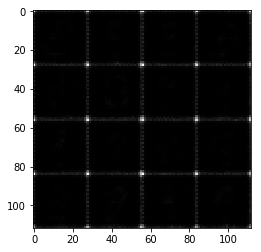

Epoch 1/2, Discriminator Loss: 1.4934, Generator Loss: 0.5297
Epoch 1/2, Discriminator Loss: 1.9459, Generator Loss: 0.2933
Epoch 1/2, Discriminator Loss: 1.1679, Generator Loss: 0.9049
Epoch 1/2, Discriminator Loss: 1.1236, Generator Loss: 1.1213


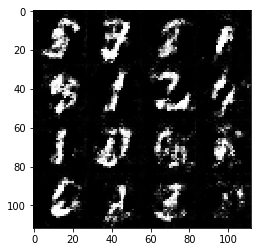

Epoch 1/2, Discriminator Loss: 1.5508, Generator Loss: 0.4667
Epoch 1/2, Discriminator Loss: 1.4570, Generator Loss: 0.5597
Epoch 1/2, Discriminator Loss: 1.5906, Generator Loss: 0.4718
Epoch 1/2, Discriminator Loss: 1.7514, Generator Loss: 0.3720


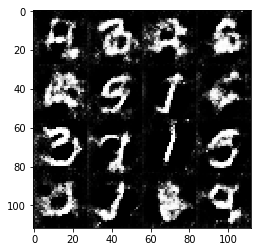

Epoch 1/2, Discriminator Loss: 1.3514, Generator Loss: 0.8117
Epoch 1/2, Discriminator Loss: 1.5786, Generator Loss: 1.3482
Epoch 1/2, Discriminator Loss: 1.3918, Generator Loss: 0.6456
Epoch 1/2, Discriminator Loss: 1.6345, Generator Loss: 0.4113


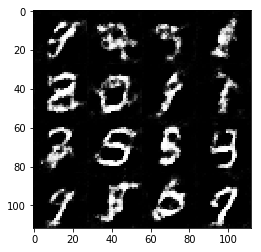

Epoch 1/2, Discriminator Loss: 1.3970, Generator Loss: 0.8970
Epoch 1/2, Discriminator Loss: 1.2926, Generator Loss: 0.7145
Epoch 1/2, Discriminator Loss: 1.5222, Generator Loss: 0.5011
Epoch 1/2, Discriminator Loss: 1.5702, Generator Loss: 0.4632


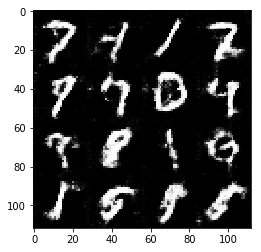

Epoch 1/2, Discriminator Loss: 1.3587, Generator Loss: 0.7174
Epoch 1/2, Discriminator Loss: 1.5431, Generator Loss: 0.4972
Epoch 1/2, Discriminator Loss: 1.3926, Generator Loss: 0.7494
Epoch 1/2, Discriminator Loss: 1.4238, Generator Loss: 0.7633


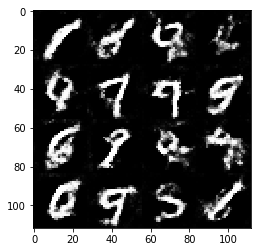

Epoch 1/2, Discriminator Loss: 1.4874, Generator Loss: 0.5261
Epoch 1/2, Discriminator Loss: 1.7056, Generator Loss: 0.3805
Epoch 1/2, Discriminator Loss: 1.5656, Generator Loss: 0.4793
Epoch 1/2, Discriminator Loss: 1.5896, Generator Loss: 0.4396


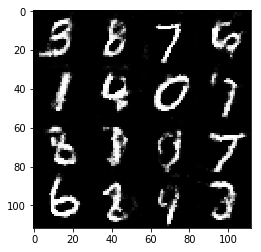

Epoch 1/2, Discriminator Loss: 1.4564, Generator Loss: 0.5395
Epoch 1/2, Discriminator Loss: 1.5063, Generator Loss: 0.5173
Epoch 1/2, Discriminator Loss: 1.9008, Generator Loss: 0.3037
Epoch 1/2, Discriminator Loss: 2.0690, Generator Loss: 0.2426


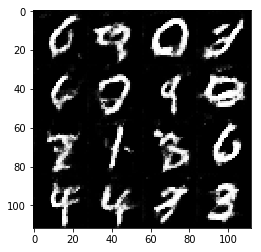

Epoch 1/2, Discriminator Loss: 1.3285, Generator Loss: 0.6551
Epoch 1/2, Discriminator Loss: 1.1706, Generator Loss: 1.0063
Epoch 1/2, Discriminator Loss: 1.3353, Generator Loss: 0.7834
Epoch 1/2, Discriminator Loss: 1.5938, Generator Loss: 0.4371


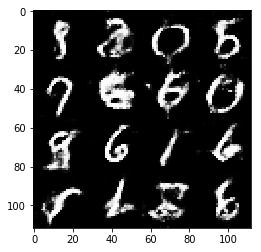

Epoch 1/2, Discriminator Loss: 1.4364, Generator Loss: 0.5964
Epoch 2/2, Discriminator Loss: 1.4382, Generator Loss: 0.5717
Epoch 2/2, Discriminator Loss: 1.3717, Generator Loss: 0.6897
Epoch 2/2, Discriminator Loss: 1.3987, Generator Loss: 0.6272


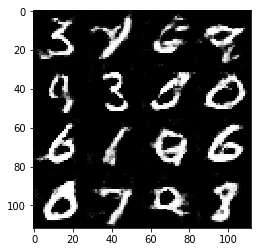

Epoch 2/2, Discriminator Loss: 1.8848, Generator Loss: 0.3033
Epoch 2/2, Discriminator Loss: 1.5461, Generator Loss: 0.4645
Epoch 2/2, Discriminator Loss: 1.7793, Generator Loss: 0.3357
Epoch 2/2, Discriminator Loss: 1.5201, Generator Loss: 0.4865


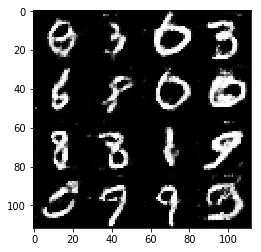

Epoch 2/2, Discriminator Loss: 1.5674, Generator Loss: 0.4701
Epoch 2/2, Discriminator Loss: 1.3879, Generator Loss: 0.6396
Epoch 2/2, Discriminator Loss: 1.4270, Generator Loss: 0.6381
Epoch 2/2, Discriminator Loss: 1.4734, Generator Loss: 0.5440


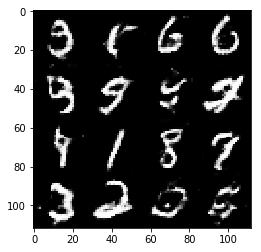

Epoch 2/2, Discriminator Loss: 1.5684, Generator Loss: 0.4493
Epoch 2/2, Discriminator Loss: 1.5269, Generator Loss: 0.4691
Epoch 2/2, Discriminator Loss: 1.5580, Generator Loss: 0.4651
Epoch 2/2, Discriminator Loss: 1.3183, Generator Loss: 0.8960


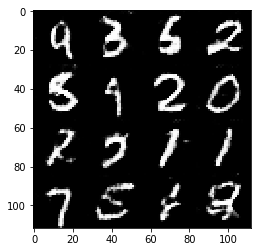

Epoch 2/2, Discriminator Loss: 1.6051, Generator Loss: 0.4394
Epoch 2/2, Discriminator Loss: 1.5509, Generator Loss: 0.5221
Epoch 2/2, Discriminator Loss: 1.8114, Generator Loss: 0.3659
Epoch 2/2, Discriminator Loss: 1.5358, Generator Loss: 0.5778


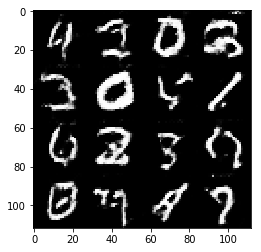

Epoch 2/2, Discriminator Loss: 1.5229, Generator Loss: 0.5134
Epoch 2/2, Discriminator Loss: 1.7825, Generator Loss: 0.3515
Epoch 2/2, Discriminator Loss: 1.3816, Generator Loss: 0.7234
Epoch 2/2, Discriminator Loss: 1.3603, Generator Loss: 0.6321


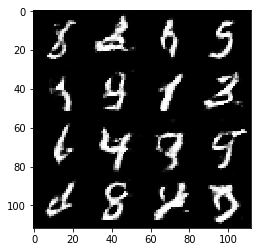

Epoch 2/2, Discriminator Loss: 1.4359, Generator Loss: 0.5660
Epoch 2/2, Discriminator Loss: 1.4783, Generator Loss: 0.5174
Epoch 2/2, Discriminator Loss: 1.5957, Generator Loss: 0.4484
Epoch 2/2, Discriminator Loss: 1.4673, Generator Loss: 0.5363


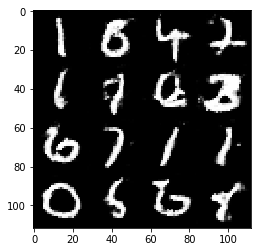

Epoch 2/2, Discriminator Loss: 1.4741, Generator Loss: 0.6073
Epoch 2/2, Discriminator Loss: 1.3867, Generator Loss: 0.7096
Epoch 2/2, Discriminator Loss: 1.6484, Generator Loss: 0.4137
Epoch 2/2, Discriminator Loss: 1.8507, Generator Loss: 0.3094


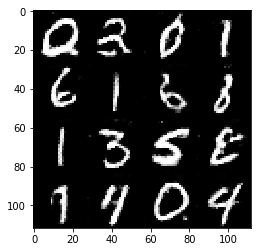

Epoch 2/2, Discriminator Loss: 1.5711, Generator Loss: 0.4413
Epoch 2/2, Discriminator Loss: 1.3854, Generator Loss: 0.6666
Epoch 2/2, Discriminator Loss: 1.6341, Generator Loss: 0.4351
Epoch 2/2, Discriminator Loss: 1.5287, Generator Loss: 0.4760


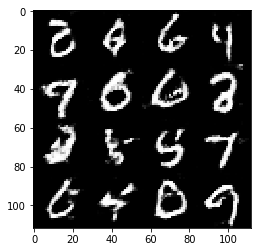

Epoch 2/2, Discriminator Loss: 1.4871, Generator Loss: 0.5019
Epoch 2/2, Discriminator Loss: 1.4373, Generator Loss: 0.6934
Result after training:


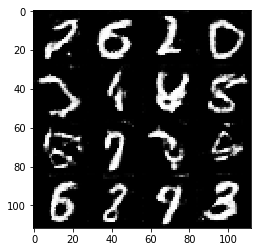

In [23]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

batch_size = 256
z_dim = 128
learning_rate = 0.0001
beta1 = 0.2

batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.1

batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.1
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, Discriminator Loss: 1.4140, Generator Loss: 0.3720
Epoch 1/1, Discriminator Loss: 1.1379, Generator Loss: 0.8111
Epoch 1/1, Discriminator Loss: 1.4659, Generator Loss: 0.2245
Epoch 1/1, Discriminator Loss: 0.9545, Generator Loss: 0.6581


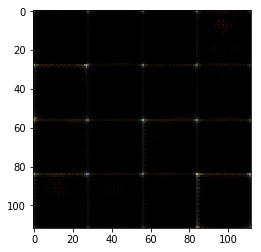

Epoch 1/1, Discriminator Loss: 1.1377, Generator Loss: 0.3660
Epoch 1/1, Discriminator Loss: 0.7860, Generator Loss: 1.4143
Epoch 1/1, Discriminator Loss: 1.4650, Generator Loss: 0.3723
Epoch 1/1, Discriminator Loss: 1.6263, Generator Loss: 0.4218


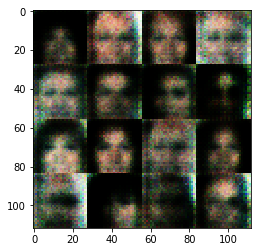

Epoch 1/1, Discriminator Loss: 1.4653, Generator Loss: 0.4097
Epoch 1/1, Discriminator Loss: 1.4238, Generator Loss: 0.4666
Epoch 1/1, Discriminator Loss: 1.4322, Generator Loss: 0.4385
Epoch 1/1, Discriminator Loss: 1.3689, Generator Loss: 0.4708


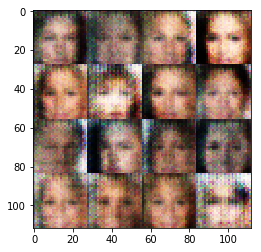

Epoch 1/1, Discriminator Loss: 1.3607, Generator Loss: 0.4815
Epoch 1/1, Discriminator Loss: 1.3647, Generator Loss: 0.4514
Epoch 1/1, Discriminator Loss: 1.3717, Generator Loss: 0.4696
Epoch 1/1, Discriminator Loss: 1.3691, Generator Loss: 0.4600


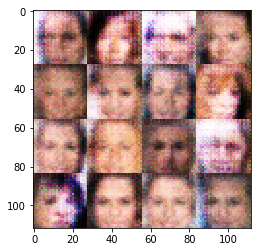

Epoch 1/1, Discriminator Loss: 1.3652, Generator Loss: 0.4766
Epoch 1/1, Discriminator Loss: 1.3469, Generator Loss: 0.4756
Epoch 1/1, Discriminator Loss: 1.3423, Generator Loss: 0.4967
Epoch 1/1, Discriminator Loss: 1.3458, Generator Loss: 0.4955


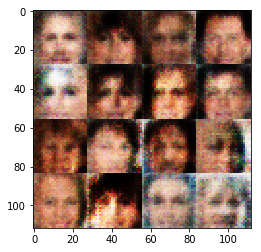

Epoch 1/1, Discriminator Loss: 1.3628, Generator Loss: 0.4749
Epoch 1/1, Discriminator Loss: 1.3598, Generator Loss: 0.4728
Epoch 1/1, Discriminator Loss: 1.3739, Generator Loss: 0.4645
Epoch 1/1, Discriminator Loss: 1.3851, Generator Loss: 0.4587


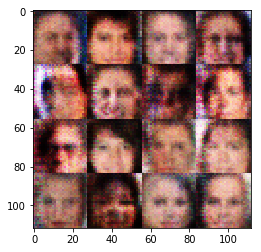

Epoch 1/1, Discriminator Loss: 1.3742, Generator Loss: 0.4734
Epoch 1/1, Discriminator Loss: 1.3464, Generator Loss: 0.4578
Epoch 1/1, Discriminator Loss: 1.2994, Generator Loss: 0.4954
Epoch 1/1, Discriminator Loss: 1.3836, Generator Loss: 0.4586


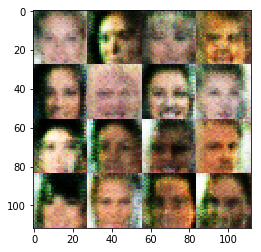

Epoch 1/1, Discriminator Loss: 1.4272, Generator Loss: 0.4441
Epoch 1/1, Discriminator Loss: 1.3323, Generator Loss: 0.5052
Epoch 1/1, Discriminator Loss: 1.3675, Generator Loss: 0.4638
Epoch 1/1, Discriminator Loss: 1.3514, Generator Loss: 0.4763


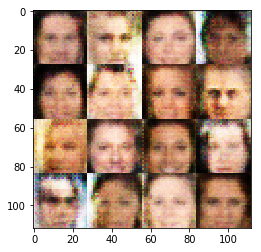

Epoch 1/1, Discriminator Loss: 1.3744, Generator Loss: 0.4770
Epoch 1/1, Discriminator Loss: 1.3450, Generator Loss: 0.4806
Epoch 1/1, Discriminator Loss: 1.3357, Generator Loss: 0.4762
Epoch 1/1, Discriminator Loss: 1.3626, Generator Loss: 0.4706


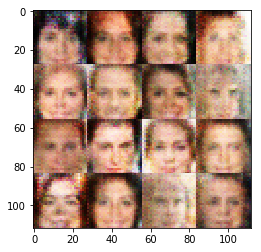

Epoch 1/1, Discriminator Loss: 1.3425, Generator Loss: 0.4833
Epoch 1/1, Discriminator Loss: 1.3589, Generator Loss: 0.4753
Epoch 1/1, Discriminator Loss: 1.4000, Generator Loss: 0.4670
Epoch 1/1, Discriminator Loss: 1.3611, Generator Loss: 0.4762


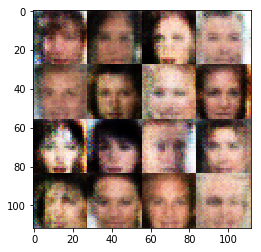

Epoch 1/1, Discriminator Loss: 1.3024, Generator Loss: 0.5024
Epoch 1/1, Discriminator Loss: 1.3963, Generator Loss: 0.4496
Epoch 1/1, Discriminator Loss: 1.3826, Generator Loss: 0.4666
Epoch 1/1, Discriminator Loss: 1.3706, Generator Loss: 0.4601


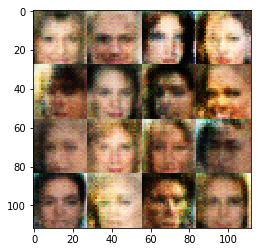

Epoch 1/1, Discriminator Loss: 1.3218, Generator Loss: 0.5030
Epoch 1/1, Discriminator Loss: 1.3557, Generator Loss: 0.4515
Epoch 1/1, Discriminator Loss: 1.4124, Generator Loss: 0.4268
Epoch 1/1, Discriminator Loss: 1.3648, Generator Loss: 0.3827


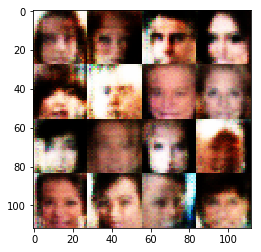

Epoch 1/1, Discriminator Loss: 1.2703, Generator Loss: 0.5579
Epoch 1/1, Discriminator Loss: 1.1003, Generator Loss: 0.8506
Epoch 1/1, Discriminator Loss: 1.4633, Generator Loss: 0.3981
Epoch 1/1, Discriminator Loss: 1.1476, Generator Loss: 0.6679


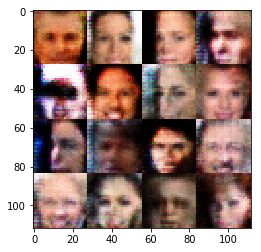

Epoch 1/1, Discriminator Loss: 1.2786, Generator Loss: 0.4821
Epoch 1/1, Discriminator Loss: 1.3879, Generator Loss: 0.3288
Epoch 1/1, Discriminator Loss: 1.3272, Generator Loss: 0.3550
Epoch 1/1, Discriminator Loss: 1.3200, Generator Loss: 0.3493


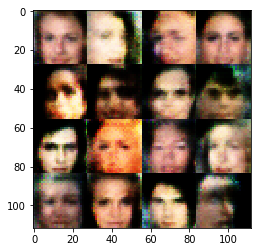

Epoch 1/1, Discriminator Loss: 1.3316, Generator Loss: 0.4019
Epoch 1/1, Discriminator Loss: 1.4034, Generator Loss: 0.3887
Epoch 1/1, Discriminator Loss: 1.3826, Generator Loss: 0.5074
Epoch 1/1, Discriminator Loss: 0.9491, Generator Loss: 1.3559


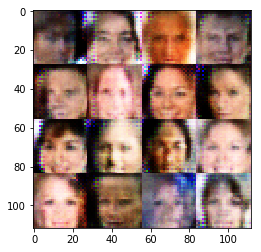

Epoch 1/1, Discriminator Loss: 1.4041, Generator Loss: 0.4576
Epoch 1/1, Discriminator Loss: 1.0963, Generator Loss: 0.7451
Epoch 1/1, Discriminator Loss: 1.2116, Generator Loss: 0.5158
Result after training:


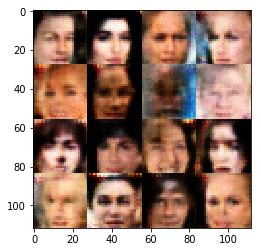

In [25]:
batch_size = 128
z_dim = 64
learning_rate = 0.0001
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.